Missing values in control dataset:
repo_full_name         0
month                  0
new_stars              0
new_forks              0
commit_count           0
new_prs                0
active_contributors    0
cumulative_stars       0
cumulative_forks       0
dtype: int64

Missing values in treatment dataset:
repo_full_name         0
repo_url               0
month                  0
hn_submission_date     0
source                 0
hn_score               0
new_stars              0
new_forks              0
commit_count           0
new_prs                0
active_contributors    0
cumulative_stars       0
cumulative_forks       0
submission_month       0
dtype: int64

Control dataset summary:
          new_stars     new_forks  cumulative_stars  cumulative_forks
count  82500.000000  82500.000000      82500.000000      82500.000000
mean       0.463273      0.003382          8.181891          0.111527
std       12.489937      0.329998        236.777076          1.941048
min        0.000000 

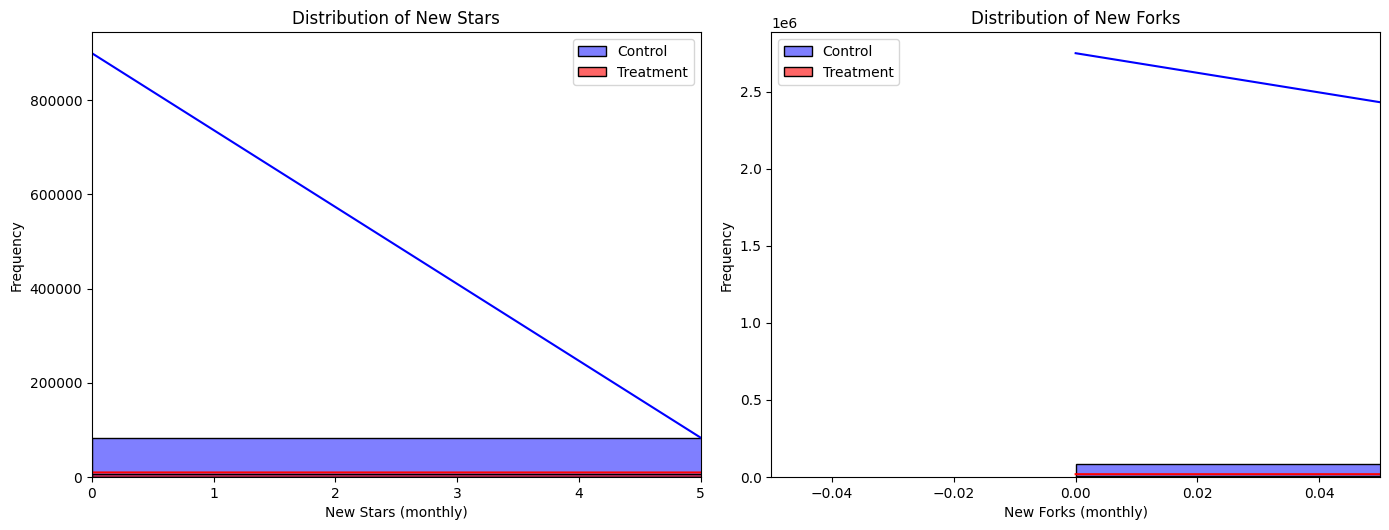


DiD Results for cumulative_stars:
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -2.387e+15   6.48e+16     -0.037      0.971   -1.29e+17    1.25e+17
treated       2.387e+15   6.93e+16      0.034      0.973   -1.33e+17    1.38e+17
post         -2.376e+15   6.36e+16     -0.037      0.970   -1.27e+17    1.22e+17
treated_post  2.376e+15   6.59e+16      0.036      0.971   -1.27e+17    1.32e+17

DiD Results for cumulative_forks:
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -3.638e+14   1.12e+16     -0.033      0.974   -2.23e+16    2.16e+16
treated       3.638e+14   1.15e+16      0.032      0.975   -2.22e+16    2.29e+16
post         -3.621e+14   1.01e+16     -0.036      0.971   -2.01e+16    1.93e+16
treated_post  3.621e+14   1.05e+16     

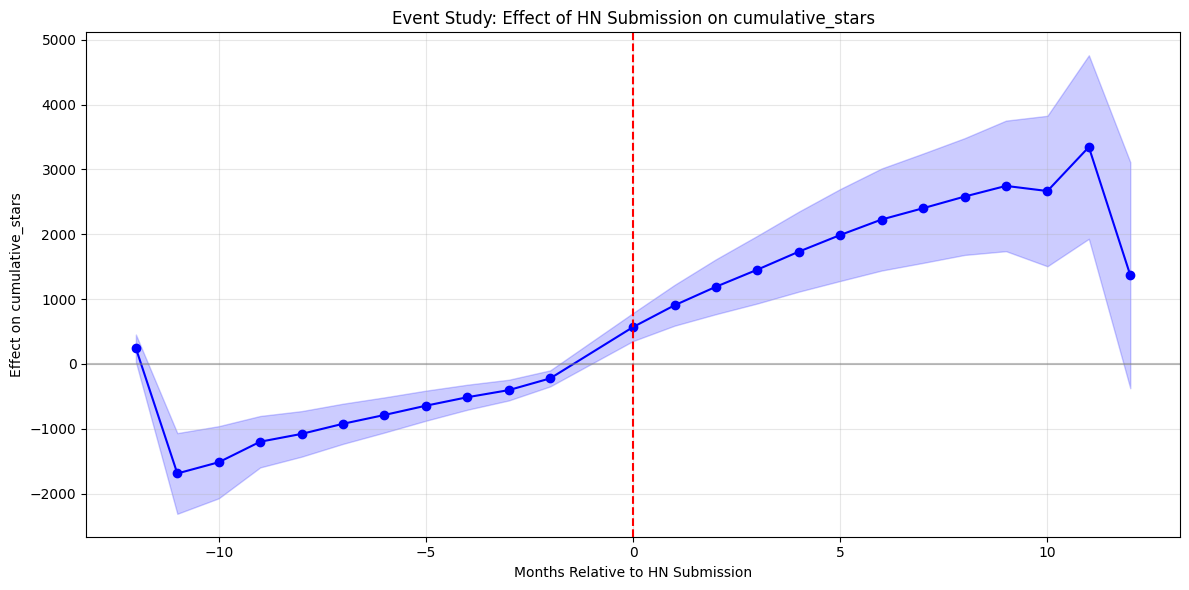

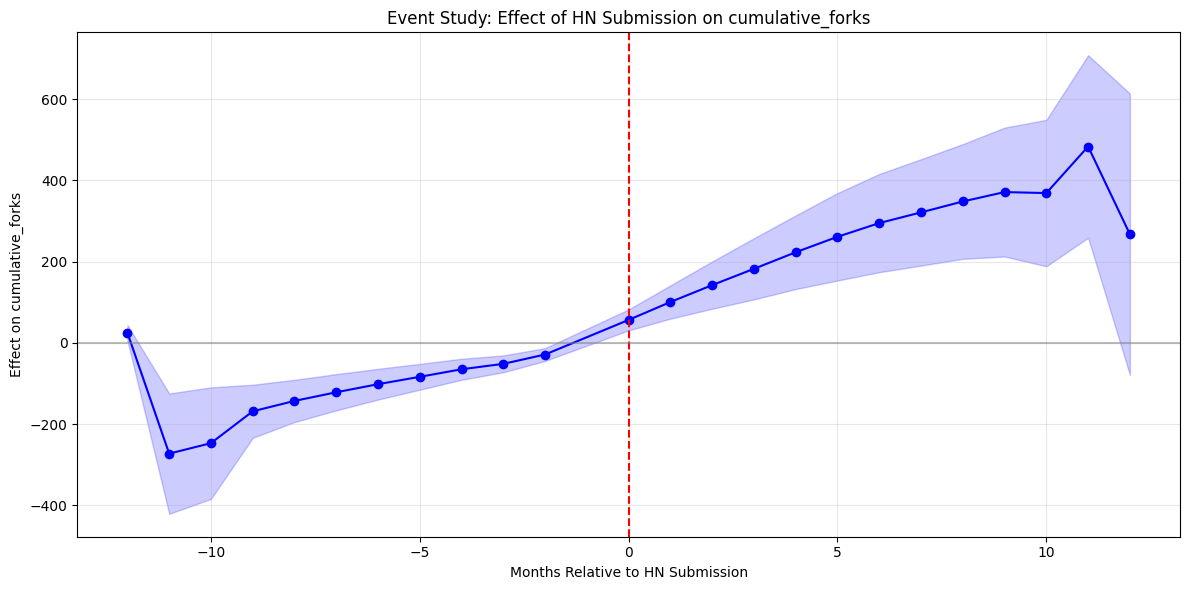

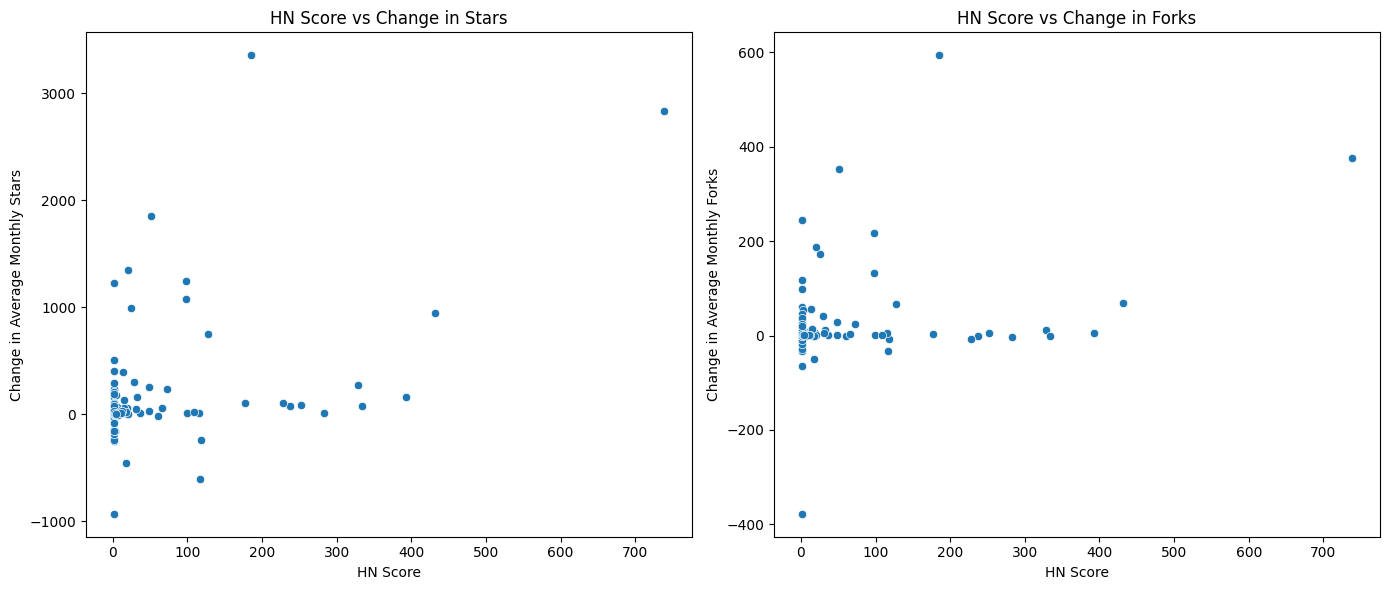

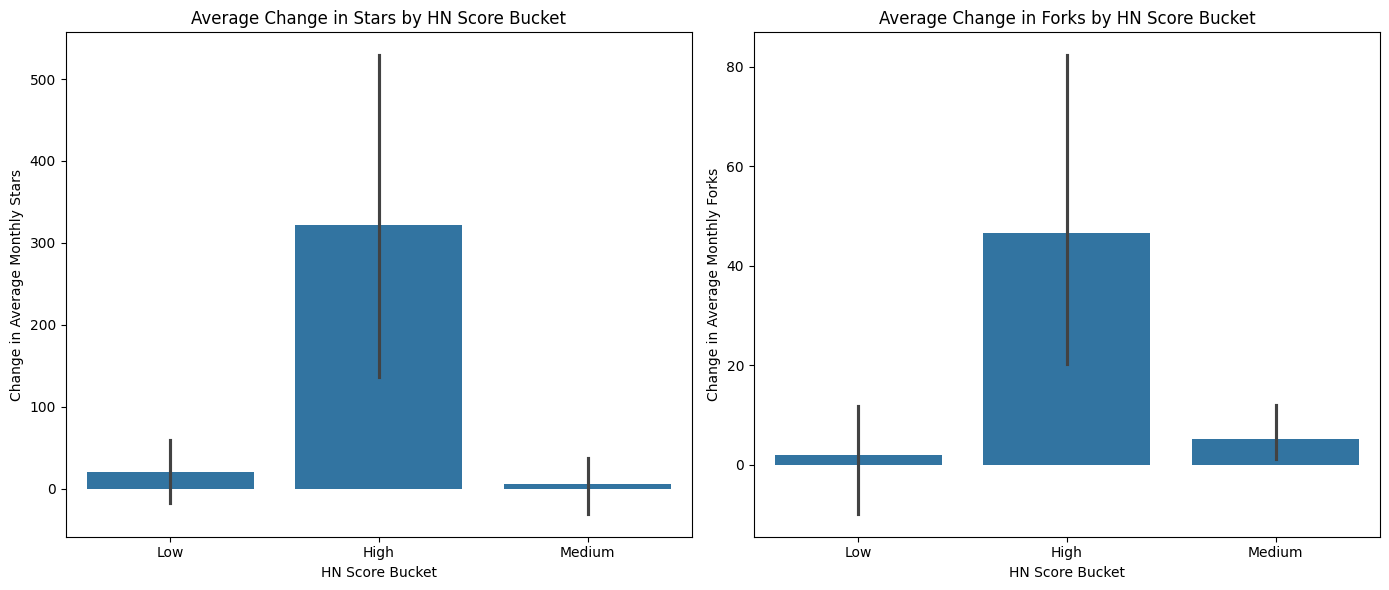


Placebo Test Results for cumulative_stars:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4504      1.124      3.069      0.002       1.247       5.654
post           9.1130      6.087      1.497      0.134      -2.817      21.043

Placebo Test Results for cumulative_forks:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1069      0.031      3.419      0.001       0.046       0.168
post           0.0090      0.022      0.408      0.683      -0.034       0.052

=== SUMMARY FINDINGS ===

Outcome: cumulative_stars
Average Treatment Effect: 2375898743279789.0000
p-value: 0.9713
Relative effect: nan% change from baseline
The effect is not statistically significant at the 5% level.

Outcome: cumulative_forks
Average Treatment Effect: 362089

In [7]:
# Staggered Difference-in-Differences Analysis: HackerNews Impact on GitHub AI Projects
# -----------------------------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels.formula.api as smf
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import warnings
warnings.filterwarnings('ignore')

# 1. Data Loading and Preprocessing
# ---------------------------------

# Load datasets
# control_df = pd.read_csv('nonhn-gh-ai-metrics-v2.csv')
control_df = pd.read_csv('./nonhn-gh-ai-monthly-metrics-v3.csv')
treatment_df = pd.read_csv('./filter-6months-repo-creation/filtered_metrics_for_did.csv')

# Convert month to datetime format
control_df['month'] = pd.to_datetime(control_df['month'])
treatment_df['month'] = pd.to_datetime(treatment_df['month'])

# Convert HN submission date to datetime format
treatment_df['hn_submission_date'] = pd.to_datetime(treatment_df['hn_submission_date'])

# Extract submission month for alignment with monthly data
treatment_df['submission_month'] = treatment_df['hn_submission_date'].dt.strftime('%Y-%m')
treatment_df['submission_month'] = pd.to_datetime(treatment_df['submission_month'])

# Check for missing values
print("Missing values in control dataset:")
print(control_df.isnull().sum())
print("\nMissing values in treatment dataset:")
print(treatment_df.isnull().sum())

# 2. Exploratory Data Analysis
# ----------------------------

# Basic statistics
print("\nControl dataset summary:")
print(control_df[['new_stars', 'new_forks', 'cumulative_stars', 'cumulative_forks']].describe())

print("\nTreatment dataset summary:")
print(treatment_df[['new_stars', 'new_forks', 'cumulative_stars', 'cumulative_forks', 'hn_score']].describe())

# Count number of repositories in each group
control_repo_count = control_df['repo_full_name'].nunique()
treatment_repo_count = treatment_df['repo_full_name'].nunique()
print(f"\nNumber of control repositories: {control_repo_count}")
print(f"Number of treatment repositories: {treatment_repo_count}")

# Visualize distribution of key metrics
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.histplot(control_df['new_stars'], bins=30, kde=True, color='blue', label='Control')
sns.histplot(treatment_df['new_stars'], bins=30, kde=True, color='red', alpha=0.6, label='Treatment')
plt.title('Distribution of New Stars')
plt.xlabel('New Stars (monthly)')
plt.ylabel('Frequency')
plt.legend()
plt.xlim(0, control_df['new_stars'].quantile(0.99))  # Limit x-axis to 99th percentile

plt.subplot(2, 2, 2)
sns.histplot(control_df['new_forks'], bins=30, kde=True, color='blue', label='Control')
sns.histplot(treatment_df['new_forks'], bins=30, kde=True, color='red', alpha=0.6, label='Treatment')
plt.title('Distribution of New Forks')
plt.xlabel('New Forks (monthly)')
plt.ylabel('Frequency')
plt.legend()
plt.xlim(0, control_df['new_forks'].quantile(0.99))  # Limit x-axis to 99th percentile

plt.tight_layout()
plt.show()

# 3. Preparation for Staggered DiD
# --------------------------------

# Create a combined dataset for analysis
treatment_df['treated'] = 1
control_df['treated'] = 0
control_df['hn_submission_date'] = None
control_df['submission_month'] = None
control_df['hn_score'] = 0

# Only keep columns needed for analysis
treatment_cols = ['repo_full_name', 'month', 'treated', 'submission_month',
                  'new_stars', 'new_forks', 'cumulative_stars', 'cumulative_forks']
control_cols = ['repo_full_name', 'month', 'treated', 'submission_month',
                'new_stars', 'new_forks', 'cumulative_stars', 'cumulative_forks']

treatment_clean = treatment_df[treatment_cols]
control_clean = control_df[control_cols]

# Combine datasets
combined_df = pd.concat([treatment_clean, control_clean], ignore_index=True)

# Create a panel dataset
combined_df = combined_df.sort_values(['repo_full_name', 'month'])

# Create relative time variable (months relative to HN submission)
# For treated repositories: calculated based on submission date
# For control repositories: will be set to NaN
combined_df['rel_month'] = np.nan

for repo in combined_df[combined_df['treated'] == 1]['repo_full_name'].unique():
    repo_data = combined_df[combined_df['repo_full_name'] == repo]
    submission_month = repo_data['submission_month'].iloc[0]

    if pd.notna(submission_month):
        # Calculate months since submission for this repository
        repo_months = combined_df[combined_df['repo_full_name'] == repo]['month']
        months_since_submission = [(m.year - submission_month.year) * 12 +
                                  (m.month - submission_month.month)
                                  for m in repo_months]

        # Update rel_month for this repository
        combined_df.loc[combined_df['repo_full_name'] == repo, 'rel_month'] = months_since_submission

# Create event-time dummy variables for staggered DiD - using string format to avoid patsy formula issues
time_window = range(-12, 13)  # 12 months before and after treatment

# Create renamed columns for event-time dummy variables to avoid issues with negative numbers in formula
for t in time_window:
    if t == -1:  # Skip -1 as reference period
        continue
    # Use a naming convention without negative signs (e.g., 'rm_n12' for -12, 'rm_p12' for +12)
    if t < 0:
        col_name = f'rm_n{abs(t)}'  # negative months: rm_n1, rm_n2, etc.
    else:
        col_name = f'rm_p{t}'  # positive months: rm_p0, rm_p1, etc.

    combined_df[col_name] = (combined_df['rel_month'] == t).astype(int)

# Dummy for all pre-treatment periods (<= -12)
combined_df['pre_treatment'] = (combined_df['rel_month'] <= min(time_window)).astype(int)

# Dummy for all post-treatment periods (>= 12)
combined_df['post_treatment'] = (combined_df['rel_month'] >= max(time_window)).astype(int)

# 4. Staggered DiD Analysis
# -------------------------

# 4.1 Calculate average treatment effects for each outcome

outcomes = ['cumulative_stars', 'cumulative_forks']
results = {}

for outcome in outcomes:
    # Convert data to proper panel format
    panel_data = combined_df.dropna(subset=['rel_month']).copy()

    # Create post-treatment indicator
    panel_data['post'] = (panel_data['rel_month'] >= 0).astype(int)

    # Create interaction term
    panel_data['treated_post'] = panel_data['treated'] * panel_data['post']

    # Set up the regression formula (basic DiD)
    formula = f"{outcome} ~ treated + post + treated_post"
    model = smf.ols(formula=formula, data=panel_data)
    result = model.fit(cov_type='cluster', cov_kwds={'groups': panel_data['repo_full_name']})

    # Store the results
    results[outcome] = result

    print(f"\nDiD Results for {outcome}:")
    print(result.summary().tables[1])

# 4.2 Event Study Analysis to check for pre-trends and dynamic effects
for outcome in outcomes:
    # Create formula for event study with fixed column names
    # We'll use only treated repos for easier visualization
    treated_data = combined_df[combined_df['treated'] == 1].dropna(subset=['rel_month'])

    # Create a proper formula with renamed columns (avoiding negative signs)
    negative_terms = [f'rm_n{i}' for i in range(2, 13)]  # n2 to n12 (skipping n1 as reference)
    positive_terms = [f'rm_p{i}' for i in range(0, 13)]  # p0 to p12

    # Combine all terms for the formula
    all_terms = negative_terms + positive_terms + ['pre_treatment', 'post_treatment']
    formula = f"{outcome} ~ " + " + ".join(all_terms)

    model = smf.ols(formula=formula, data=treated_data)
    result = model.fit(cov_type='cluster', cov_kwds={'groups': treated_data['repo_full_name']})

    # Extract coefficients and confidence intervals for plotting
    coefs = result.params
    conf_ints = result.conf_int()

    # Map coefficients back to relative months for plotting
    coef_map = {}
    conf_lower_map = {}
    conf_upper_map = {}

    # Process negative months
    for i in range(2, 13):
        col = f'rm_n{i}'
        if col in coefs:
            coef_map[-i] = coefs[col]
            conf_lower_map[-i] = conf_ints.loc[col, 0]
            conf_upper_map[-i] = conf_ints.loc[col, 1]

    # Process positive months (including zero)
    for i in range(0, 13):
        col = f'rm_p{i}'
        if col in coefs:
            coef_map[i] = coefs[col]
            conf_lower_map[i] = conf_ints.loc[col, 0]
            conf_upper_map[i] = conf_ints.loc[col, 1]

    # Prepare data for plotting
    periods = sorted(coef_map.keys())
    coef_values = [coef_map[p] for p in periods]
    conf_lower = [conf_lower_map[p] for p in periods]
    conf_upper = [conf_upper_map[p] for p in periods]

    # Plot event study
    plt.figure(figsize=(12, 6))
    plt.plot(periods, coef_values, 'o-', color='blue')
    plt.fill_between(periods, conf_lower, conf_upper, alpha=0.2, color='blue')

    plt.axvline(x=0, color='red', linestyle='--')
    plt.axhline(y=0, color='gray', linestyle='-', alpha=0.5)

    plt.xlabel('Months Relative to HN Submission')
    plt.ylabel(f'Effect on {outcome}')
    plt.title(f'Event Study: Effect of HN Submission on {outcome}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 5. Heterogeneity Analysis
# -------------------------
# Examine if HN score influences the size of the effect

if 'hn_score' in treatment_df.columns:
    # Create bins for HN score
    treatment_analysis = treatment_df.copy()
    treatment_analysis['score_bucket'] = pd.qcut(treatment_analysis['hn_score'], 3,
                                              labels=['Low', 'Medium', 'High'])

    # Calculate average pre/post metrics by score bucket
    pre_post_by_score = []

    for repo in treatment_analysis['repo_full_name'].unique():
        repo_data = treatment_analysis[treatment_analysis['repo_full_name'] == repo]
        submission_date = repo_data['submission_month'].iloc[0]

        if pd.isna(submission_date):
            continue

        pre_data = repo_data[repo_data['month'] < submission_date]
        post_data = repo_data[repo_data['month'] >= submission_date]

        pre_stars = pre_data['new_stars'].mean() if not pre_data.empty else 0
        post_stars = post_data['new_stars'].mean() if not post_data.empty else 0

        pre_forks = pre_data['new_forks'].mean() if not pre_data.empty else 0
        post_forks = post_data['new_forks'].mean() if not post_data.empty else 0

        score = repo_data['hn_score'].iloc[0]
        score_bucket = repo_data['score_bucket'].iloc[0]

        pre_post_by_score.append({
            'repo': repo,
            'score': score,
            'score_bucket': score_bucket,
            'pre_stars': pre_stars,
            'post_stars': post_stars,
            'pre_forks': pre_forks,
            'post_forks': post_forks,
            'stars_change': post_stars - pre_stars,
            'forks_change': post_forks - pre_forks
        })

    score_df = pd.DataFrame(pre_post_by_score)

    # Plot the relationship between HN score and effect size
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x='score', y='stars_change', data=score_df)
    plt.title('HN Score vs Change in Stars')
    plt.xlabel('HN Score')
    plt.ylabel('Change in Average Monthly Stars')

    plt.subplot(1, 2, 2)
    sns.scatterplot(x='score', y='forks_change', data=score_df)
    plt.title('HN Score vs Change in Forks')
    plt.xlabel('HN Score')
    plt.ylabel('Change in Average Monthly Forks')

    plt.tight_layout()
    plt.show()

    # Bar chart showing average effect by score bucket
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.barplot(x='score_bucket', y='stars_change', data=score_df)
    plt.title('Average Change in Stars by HN Score Bucket')
    plt.xlabel('HN Score Bucket')
    plt.ylabel('Change in Average Monthly Stars')

    plt.subplot(1, 2, 2)
    sns.barplot(x='score_bucket', y='forks_change', data=score_df)
    plt.title('Average Change in Forks by HN Score Bucket')
    plt.xlabel('HN Score Bucket')
    plt.ylabel('Change in Average Monthly Forks')

    plt.tight_layout()
    plt.show()

# 6. Robustness Checks
# --------------------

# 6.1 Placebo test: random assignment of treatment dates to control group
np.random.seed(42)  # For reproducibility

# Create a placebo dataset from control repositories
placebo_df = control_df.copy()

# Assign random submission dates to control repositories
control_repos = placebo_df['repo_full_name'].unique()
for repo in control_repos:
    # Get a random date in the middle of the time range to simulate submission
    repo_data = placebo_df[placebo_df['repo_full_name'] == repo]
    all_months = repo_data['month'].unique()

    if len(all_months) > 3:  # Only use repos with sufficient data
        # Pick a month in the middle third of the data
        start_idx = len(all_months) // 3
        end_idx = start_idx * 2
        random_month_idx = np.random.randint(start_idx, end_idx)
        random_month = all_months[random_month_idx]

        # Assign the random month as the "submission date"
        placebo_df.loc[placebo_df['repo_full_name'] == repo, 'submission_month'] = random_month

# Calculate relative months for placebo group
placebo_df['rel_month'] = np.nan

for repo in placebo_df['repo_full_name'].unique():
    repo_data = placebo_df[placebo_df['repo_full_name'] == repo]
    submission_month = repo_data['submission_month'].iloc[0]

    if pd.notna(submission_month):
        # Calculate months since submission for this repository
        repo_months = placebo_df[placebo_df['repo_full_name'] == repo]['month']
        months_since_submission = [(m.year - submission_month.year) * 12 +
                                  (m.month - submission_month.month)
                                  for m in repo_months]

        # Update rel_month for this repository
        placebo_df.loc[placebo_df['repo_full_name'] == repo, 'rel_month'] = months_since_submission

# Create post indicator
placebo_df['post'] = (placebo_df['rel_month'] >= 0).astype(int)

# Run placebo DiD regression
for outcome in outcomes:
    formula = f"{outcome} ~ post"
    placebo_model = smf.ols(formula=formula, data=placebo_df.dropna(subset=['rel_month']))
    placebo_result = placebo_model.fit(cov_type='cluster',
                                      cov_kwds={'groups': placebo_df['repo_full_name']})

    print(f"\nPlacebo Test Results for {outcome}:")
    print(placebo_result.summary().tables[1])

# 7. Conclusions
# --------------
print("\n=== SUMMARY FINDINGS ===")
for outcome in outcomes:
    result = results[outcome]
    effect = result.params['treated_post']
    pvalue = result.pvalues['treated_post']

    # Calculate percentage effect (relative to pre-treatment control mean)
    pre_treatment_control = combined_df[(combined_df['treated'] == 0) &
                                       (combined_df['rel_month'] < 0)]
    baseline = pre_treatment_control[outcome].mean()

    if baseline != 0:
        percent_effect = (effect / baseline) * 100
    else:
        percent_effect = float('inf')

    print(f"\nOutcome: {outcome}")
    print(f"Average Treatment Effect: {effect:.4f}")
    print(f"p-value: {pvalue:.4f}")

    if pvalue < 0.05:
        significance = "statistically significant"
    else:
        significance = "not statistically significant"

    if baseline != 0:
        print(f"Relative effect: {percent_effect:.2f}% change from baseline")

    print(f"The effect is {significance} at the 5% level.")